### Rock paper scissor: Multi-class classifier

In [36]:
# Import packages

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import os
from jupyterthemes import jtplot

#### Inspect the data

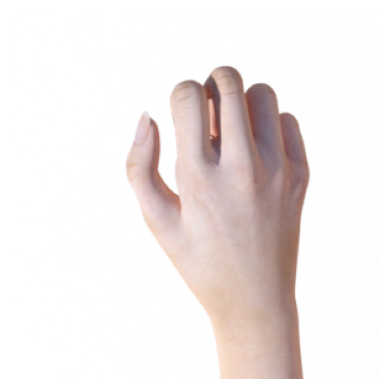

In [21]:
base_dir = os.path.join(os.getcwd(), "Data/rps/")

rock_dir = os.path.join(base_dir, "rock")
paper_dir = os.path.join(base_dir, "paper")
scissor_dir = os.path.join(base_dir, "scissor")

img = mpimg.imread(os.path.join(rock_dir, "rock01-002.png"))
plt.imshow(img)
plt.axis("off")
plt.show()

#### Create and pre-process the datasets

In [23]:
training_dir = base_dir
validation_dir = os.path.join(os.getcwd(), "Data/rps-test-set/")

training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                              image_size=(150, 150),
                                                              batch_size=32,
                                                              label_mode='categorical')

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 image_size=(150, 150),
                                                                 batch_size=32,
                                                                 label_mode='categorical')


# Pre-process data
training_dataset = training_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


### Modelling

    1. Create the model
    2. Compile the model
    3. Train the model

In [30]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomContrast(0.4)
])

model = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    augmentation_layers,
    tf.keras.layers.Rescaling(1./255),
    # Conv 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Conv 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Conv 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Conv 4
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # Fully connected layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# tf.keras.utils.plot_model(model, show_layer_names=True, show_dtype=True, show_trainable=True, dpi=50)

In [31]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

In [32]:
# Train the model
history = model.fit(training_dataset, epochs=25, validation_data=validation_dataset)

Epoch 1/25


2025-06-27 01:28:08.926294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.3422 - loss: 1.1091 - val_accuracy: 0.3333 - val_loss: 1.1370
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3948 - loss: 1.0846 - val_accuracy: 0.3898 - val_loss: 1.0347
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.4325 - loss: 1.0520 - val_accuracy: 0.5349 - val_loss: 0.9774
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.4847 - loss: 0.9974 - val_accuracy: 0.7177 - val_loss: 0.8240
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5617 - loss: 0.9143 - val_accuracy: 0.7930 - val_loss: 0.7259
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5849 - loss: 0.8819 - val_accuracy: 0.6478 - val_loss: 0.7554
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6325 - loss: 0.7992 - val_accuracy: 0.7823 - val_loss: 0.5834
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6856 - loss: 0.7244 - val_accuracy: 0.4919 - val_loss: 

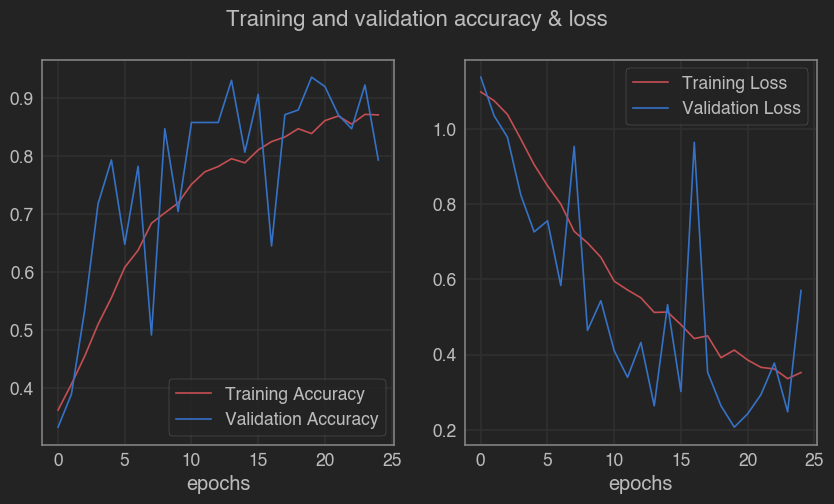

In [45]:
jtplot.style(theme='monokai')

# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy & loss')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()